# Figure 2
In this notebook, we reproduce panels from Figure 2. Plots involving experimental data cannot be included, however, as this data is owned by the original authors and can only be distributed with their permission.

We first import the necessary packages, i.e. `NumPy`, `SciPy`, `PyTorch`, and `Matplotlib`.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerTuple
import matplotlib.colors as mcolors
from scipy.stats import ttest_ind_from_stats

We define some layout settings for the plots and a few other auxiliary variables.

In [2]:
plt.rcParams.update({'pdf.fonttype': 42,
                     'pdf.use14corefonts': False,
                     'ps.useafm': False,
                     'figure.constrained_layout.use': True,
                     'figure.dpi': 150,
                     'font.size': 7,
                     'figure.titlesize': 7,
                     'figure.labelsize': 7,
                     'axes.labelsize': 7,
                     'axes.labelpad': 2,
                     'axes.titlesize': 7,
                     'axes.titlepad': 2,
                     'figure.titlesize': 7,
                     'figure.labelweight': 'light',
                     'figure.titleweight': 'light',
                     'axes.labelweight': 'light',
                     'axes.titleweight': 'light',
                     'font.family': 'sans-serif',
                     'font.sans-serif': 'Arial',
                     'font.weight': 'light',
                     'mathtext.fontset': 'custom',
                     'mathtext.it': 'Arial:italic',
                     'mathtext.bf': 'Arial:bold',
                     'mathtext.sf': 'Arial:light',
                     'mathtext.default': 'sf',
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth': 0.5,
                     'xtick.major.size': 2.5,
                     'xtick.minor.size': 1.5,
                     'ytick.major.size': 2.5,
                     'ytick.minor.size': 1.5,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.5,
                     'xtick.major.pad': 3.5/3,
                     'xtick.minor.pad': 3.5/3,
                     'ytick.major.pad': 3.5/3,
                     'ytick.minor.pad': 3.5/3,
                     'lines.linewidth': 1.5,
                     'lines.markersize': 4.,
                     'hatch.color': 'w',
                     'hatch.linewidth': 0.5,})

blues = plt.cm.Blues(np.linspace(0.95,0.35,4))
greens = plt.cm.Greens(np.linspace(0.9,0.35,4))
oranges = plt.cm.YlOrBr(np.linspace(0.9,0.3,4))
reds = plt.cm.Reds(np.linspace(0.8,0.2,4))
purples = plt.cm.Purples(np.linspace(0.8,0.2,4))
greys = plt.cm.Greys(np.linspace(0.8,0.2,4))
mygray = np.ones(3)*0.90

mm = 1/2.54/10  # mm in inches
cm = 1/2.54  # cm in inches

Load data files containing the results of the simulations and the numerical solutions to the theoretical predictions. Data files are stored either as `PyTorch` binaries (`.pt`) or `NumPy` binaries (`.npy`).

In [3]:
# load to cpu
device = torch.device('cpu')

# rnn simulation with balanced patterns (f=0.5)
data_50 = torch.load('./data/rnn_f50.pt', map_location=device)

# theoretical solutions
theory_l2 = np.load('./theory/l2.npy', allow_pickle=True).item()
theory_l2_crit = np.load('./theory/l2_crit.npy', allow_pickle=True).item()
theory_l1 = np.load('./theory/l1.npy', allow_pickle=True).item()

Define parameters about the simulation and print some meta-data.

In [5]:
# critical capacities
ac_50 = theory_l2_crit['alpha_c'][0]
ac_10 = theory_l2_crit['alpha_c'][1]

# number of z-values
n_z = data_50['z'].max()

# number of storage loads
n_a = data_50['a'].shape[0]

# number of neurons
N = data_50['params']['N']

# print simulation meta data for the last run
print('date:', data_50['date'])
print('\n'.join('{}: {}'.format(k, v) for k, v in data_50['params'].items()))

date: 2024-03-30 03:47:15
N: 1000
M: 700
f: 0.5
inh_ratio: 0.0
z: 4
u0: 0.1
theta0: 0.0
length: 50
eta: 0.007000000216066837
eta_theta: 0.007000000216066837
seed: 100
n_epochs: 8750000
norm_type: u
weight_type: hadamard
optimizer_type: bp
pattern_type: bernoulli
inh_type: unbalanced
with_bias: True
kernel_degree: 1
record_on: False


## SNR with respect to different $q$-values, in networks with different $z$-values

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/1289348596.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


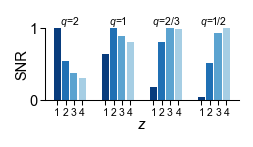

In [125]:
fig, ax = plt.subplots(figsize=(4.*cm, 2.2*cm), nrows=1, ncols=1, gridspec_kw={'height_ratios':[1]})

label_vec = ['1', '2', '3', '4']

jit = 0.2
x_vec = np.array([np.linspace(1+jit, 4-jit, 4),
                  np.linspace(6+jit, 9-jit, 4),
                  np.linspace(11+jit, 14-jit, 4),
                  np.linspace(16+jit, 19-jit, 4)])

i_a = 0

K_max = data_50['min_margin_mean'][:,0,i_a,0].max()
K_mean = data_50['min_margin_mean'][:,0,i_a,0]/K_max
K_std = data_50['min_margin_std'][:,0,i_a,0]/K_max
K_sem = data_50['min_margin_std'][:,0,i_a,0]/np.sqrt(N)/K_max

for i_z in range(n_z):
    b01 = ax.bar(x_vec[0,i_z], K_mean[i_z],
                width=0.75, capsize=2.5, color=blues[i_z], linewidth=0, error_kw={'ecolor': 'k', 'elinewidth': 0.4, 'capthick': 0.4})

ax.text(x_vec[0].mean(), 1.05, r'$\it q\!=\!2$', size=5, color=blues[0,:3]*0, ha='center')

K_max = data_50['rho_mean'][:,0,i_a,0].max()
K_mean = data_50['rho_mean'][:,0,i_a,0]/K_max
K_std = data_50['rho_std'][:,0,i_a,0]/K_max
K_sem = data_50['rho_std'][:,0,i_a,0]/np.sqrt(N)/K_max

for i_z in range(n_z):
    b01 = ax.bar(x_vec[1,i_z], K_mean[i_z],
                width=0.75, capsize=2.5, color=blues[i_z], linewidth=0, error_kw={'ecolor': 'k', 'elinewidth': 0.4, 'capthick': 0.4})

ax.text(x_vec[1].mean(), 1.05, r'$\it q\!=\!\!1$', size=5, color=blues[1,:3]*0, ha='center')

K_max = data_50['L23_margin_mean'][:,0,i_a,0].max()
K_mean = data_50['L23_margin_mean'][:,0,i_a,0]/K_max
K_std = data_50['L23_margin_std'][:,0,i_a,0]/K_max
K_sem = data_50['L23_margin_std'][:,0,i_a,0]/np.sqrt(N)/K_max

_, pval23 = ttest_ind_from_stats(mean1=K_mean[2], std1=K_std[2], nobs1=1000, mean2=K_mean[3], std2=K_std[3], nobs2=1000, equal_var=False)

for i_z in range(n_z):
    b01 = ax.bar(x_vec[2,i_z], K_mean[i_z],
                width=0.75, capsize=2.5, color=blues[i_z], linewidth=0, error_kw={'ecolor': 'k', 'elinewidth': 0.4, 'capthick': 0.4})

ax.text(x_vec[2].mean(), 1.05, r'$\it q\!=\!2/3$', size=5, color=blues[2,:3]*0, ha='center')

K_max = data_50['L24_margin_mean'][:,0,i_a,0].max()
K_mean = data_50['L24_margin_mean'][:,0,i_a,0]/K_max
K_std = data_50['L24_margin_std'][:,0,i_a,0]/K_max
K_sem = data_50['L24_margin_std'][:,0,i_a,0]/np.sqrt(N)/K_max

_, pval24 = ttest_ind_from_stats(mean1=K_mean[2], std1=K_std[2], nobs1=1000, mean2=K_mean[3], std2=K_std[3], nobs2=1000, equal_var=False)

for i_z in range(n_z):
    b01 = ax.bar(x_vec[3,i_z], K_mean[i_z],
                width=0.75, capsize=2.5, color=blues[i_z], linewidth=0, error_kw={'ecolor': 'k', 'elinewidth': 0.4, 'capthick': 0.4})

ax.text(x_vec[3].mean(), 1.05, r'$\it q\!=\!\!1/2$', size=5, color=blues[3,:3]*0, ha='center')

ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.set_xticks(x_vec.flatten(), [1, 2, 3, 4]*4, size=5)
ax.set_xlabel(r'$\it z$', labelpad=0)
ax.set_ylabel(r'SNR', labelpad=0)

fig.show()

## Neural SNR ($q=2$) for networks with different $z$-values

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/2884492408.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


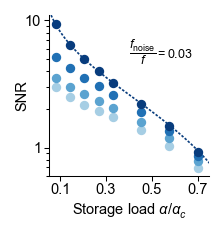

In [126]:
fig, ax = plt.subplots(figsize=(3.5*cm, 3.7*cm), nrows=1, ncols=1, gridspec_kw={'height_ratios':[1]})

f = 0.5
f_noise = 0.03*f
noise_factor = np.sqrt( f_noise + 0.25*((1-2*f)/(f*(1-f)))*f_noise**2 )
ax.plot(theory_l2['alpha_c'][:,0]/ac_50, theory_l2['k']/noise_factor, color=blues[0], linestyle=(0,(1.5,1)), lw=.8)
for i_z in range(n_z):
    jit = (i_z-1.5)*0.005
    ax.errorbar(data_50['a']/ac_50, data_50['min_margin_mean'][i_z,0,:,:].mean(dim=-1)/noise_factor, capsize=3, marker='o', color=blues[i_z], fillstyle='full', linestyle='', linewidth=0.5, zorder=10-i_z, markersize=3.5)

ax.set_yscale('log')
ax.set_xlim([0.05, 0.75])
ax.set_ylim([0.6, 11])
ax.set_xticks([0.1, 0.3, 0.5, 0.7])
ax.set_yticks([1, 10], [1, 10])
ax.set_xlabel(r'Storage load $\it{\alpha / \alpha_c}$')
ax.text(0.4, 5, r'$\dfrac{\mathit{f}_{noise}}{\mathit{f}} = 0.03$', size=6)
line1 = mlines.Line2D([], [], color=blues[0], linestyle='none', lw=2, marker='o', markersize=3)
line2 = mlines.Line2D([], [], color=blues[1], linestyle='none', lw=2, marker='o', markersize=3)
line3 = mlines.Line2D([], [], color=blues[2], linestyle='none', lw=2, marker='o', markersize=3)
line4 = mlines.Line2D([], [], color=blues[3], linestyle='none', lw=2, marker='o', markersize=3)
line5 = mlines.Line2D([], [], color='indianred', linestyle='--', lw=1.5)

ax.set_ylabel(r'SNR', labelpad=-2)

fig.show()

## Tests of pattern recall robustness

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/1519238416.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


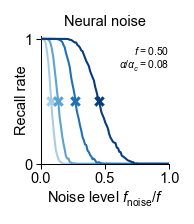

In [124]:
fig, ax1 = plt.subplots(figsize=(3*cm, 3.5*cm), nrows=1, ncols=1)

for i_z in range(n_z):
    ax1.plot(data_50['p'].numpy()/data_50['f']*2, data_50['cap_bal'][i_z,0,0,:,:].mean(dim=-2).numpy(), color=blues[i_z], fillstyle='none', marker=',', linewidth=1., zorder=100-i_z, clip_on=1)
    ax1.scatter(data_50['p'][ (data_50['cap_bal'][i_z,0,0,0,:] - 0.5).abs().argmin() ].item()/data_50['f']*2, 0.5, color=blues[i_z], marker='x', linewidth=1.5, zorder=100-i_z)
    
ax1.set_xticks([0, 0.5, 1])
ax1.set_xlim([0,1])
ax1.set_ylim([0,1.02])
ax1.set_yticks([0, 1])
ax1.set_ylabel('Recall rate', labelpad=-2)
ax1.text(1, 0.95, r' $\mathit{f}=0.50$' + '\n' + r'$\it {\alpha}/{\alpha_c} = 0.08$', size=5, ha='right', va='top')
ax1.set_title('Neural noise', y=1.05)
ax1.set_xlabel(r'Noise level $\mathit{f}_{noise}/\mathit{f}$')

fig.show()

## Maximal neural noise tolerance

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/1987293779.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


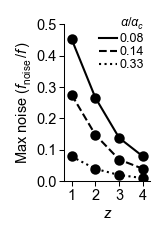

In [127]:
fig, ax = plt.subplots(figsize=(2.5*cm, 3.7*cm), nrows=1, ncols=1)

z_vec = np.array([1,2,3,4])
ls = ['-', '--', '', ':', ':', '', '']

for i_a in [0, 1, 4]:
    tol_bal = (data_50['cap_bal'][:,0,i_a,0,:]-0.5).abs().argmin(dim=1)
    tol_bal = data_50['p'][tol_bal]*2/0.5#/tol_bal.max()
    tol_iso = (data_50['cap_iso'][:,0,i_a,0,:]-0.5).abs().argmin(dim=1)
    tol_iso = data_50['p'][tol_iso]/0.5#/tol_iso.max()

    ax.plot(z_vec, tol_bal, color='k', ls=ls[i_a], marker='o', fillstyle='full', lw=1)

ax.set_xlim([0.7, 4.3])
ax.set_xticks([1,2,3,4])
ax.set_ylim([0, 0.5])
ax.set_yticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel(r'Max noise $(\mathit{f}_{noise} \, / \mathit{f} \,)$', labelpad=1)
ax.set_xlabel(r'$\it z$')

line1 = mlines.Line2D([], [], color='k', linestyle='-', lw=1, markersize=2)
line2 = mlines.Line2D([], [], color='k', linestyle='--', lw=1, markersize=2)
line3 = mlines.Line2D([], [], color='k', linestyle=':', lw=1, markersize=2)
ax.legend([line1, line2, line3], ['0.08', '0.14', '0.33'], alignment='right',
          loc=[0.4, 0.7], fontsize=6, title=r'$\it \alpha/\alpha_c$', title_fontsize=6, frameon=False, labelspacing=0.1, handletextpad=.2,  handlelength=1.5, borderpad=0)

fig.show()

## Synaptic SNR ($q=1$) for networks with different $z$-values

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/1410976324.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


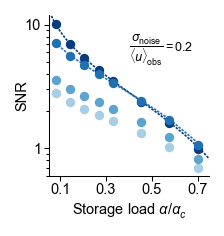

In [128]:
fig, ax = plt.subplots(figsize=(3.5*cm, 3.7*cm), nrows=1, ncols=1)

f = 0.5
mu_u = 0.1
sig_u = 0.2*mu_u

theory_bias_z1 = 0
theory_noise_z1 = np.sqrt(N*f*0.5*sig_u**2)
theory_signal_z1 = theory_l2['k']*data_50['l2_mean'][0,0,:,0].mean().numpy()
ax.plot(theory_l2['alpha_c'][:,0]/ac_50, theory_signal_z1/theory_noise_z1 - theory_bias_z1, color=blues[0], linestyle=(0,(1.5,0.8)), lw=.8)

idx_a = np.argmin(np.abs(theory_l1['alpha_c'][:,0:1] - data_50['a'][None,:].numpy()), axis=0)
theory_signal_z2 = theory_l1['rho'][idx_a]*f/np.sqrt(N)*np.sqrt(data_50['l1_mean'][1,0,:,0].numpy())
theory_noise_z2 = np.sqrt(f*sig_u**2)
ax.plot(theory_l1['alpha_c'][idx_a,0]/ac_50, theory_signal_z2/theory_noise_z2, color=blues[1], linestyle=(0,(1.5,0.8)), lw=.8)

sim_signal_z1 = data_50['syn_margin_mean'][0,0,:,0]*np.sqrt(N)
sim_noise_z1 = sig_u*np.sqrt(N*f*data_50['l0_mean'][0,0,:,0])
sim_bias_z1 = 0
ax.errorbar(data_50['a']/ac_50, (sim_signal_z1-sim_bias_z1)/sim_noise_z1, color=blues[0], capsize=3, marker='o', fillstyle='full', ls='', linewidth=0.5, markersize=3.5, zorder=8.5)

for i_z in [3,2,1]:
    noise_factor = np.sqrt(f*sig_u**2)
    ax.errorbar(data_50['a']/ac_50, data_50['syn_margin_mean'][i_z,0,:,0]/noise_factor, color=blues[i_z], capsize=3, marker='o', fillstyle='full', ls='', linewidth=0.5, markersize=3.5, zorder=10-i_z)

ax.set_yscale('log')
ax.set_xlim([0.05, 0.75])
ax.set_xticks([0.1, 0.3, 0.5, 0.7])
ax.set_ylim([0.6, 12])
ax.set_yticks([1, 10], [1, 10])
ax.set_ylabel(r'SNR', labelpad=-2)
ax.set_xlabel(r'Storage load $\it{\alpha / \alpha_c}$')
ax.text(0.4, 6, r'$\dfrac{\mathit{\sigma}_{noise}}{\langle \mathit{u} \rangle_{\!obs}} = 0.2$', size=6)

line1 = mlines.Line2D([], [], color='indianred', linestyle='--', lw=1.5)
line2 = mlines.Line2D([], [], color='lightpink', linestyle='--', lw=1.5)

fig.show()

## Tests of pattern recall robustness

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/3564788676.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


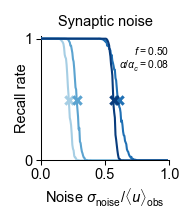

In [123]:
fig, ax1 = plt.subplots(figsize=(3*cm, 3.5*cm), nrows=1, ncols=1)

for i_z in range(n_z):
    ax1.plot(data_50['p'].numpy()*0.2/0.1, data_50['cap_syn_1mask'][i_z,0,0,0,:].numpy(), color=blues[i_z], fillstyle='none', marker=',', linewidth=1., zorder=100-i_z, clip_on=1)
    ax1.scatter(data_50['p'][ (data_50['cap_syn_1mask'][i_z,0,0,0,:] - 0.5).abs().argmin() ].item()*0.2/0.1, 0.5, color=blues[i_z], marker='x', linewidth=1.5, zorder=100-i_z)

ax1.set_xticks([0, 0.5, 1])
ax1.set_xlim([0,1])
ax1.set_ylim([0,1.02])
ax1.set_yticks([0, 1])
ax1.set_ylabel('Recall rate', labelpad=-2)
ax1.text(1., 0.95, r' $\mathit{f}=0.50$' + '\n' + r'$\it {\alpha}/{\alpha_c} = 0.08$', size=5, ha='right', va='top')
ax1.set_title('Synaptic noise', y=1.05)
ax1.set_xlabel(r'Noise $\mathit{\sigma}_{noise} / \langle \mathit{u} \rangle_{obs}$')

fig.show()

## Maximal synaptic noise tolerance

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/872736937.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


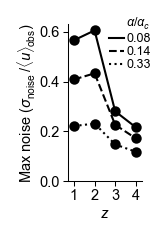

In [129]:
fig, ax = plt.subplots(figsize=(2.5*cm, 3.7*cm), nrows=1, ncols=1)

z_vec = np.array([1,2,3,4])
ls = ['-', '--', ':', ':', ':', ':', ':', ':']

for i_a in [0, 1, 4]:
    tol_syn_z = (data_50['cap_syn_z'][:,0,i_a,0,:]-0.5).abs().argmin(dim=1)
    tol_syn_z = data_50['p'][tol_syn_z]*0.1/0.1#/tol_syn.max()
    tol_syn_1 = (data_50['cap_syn_1'][:,0,i_a,0,:]-0.5).abs().argmin(dim=1)
    tol_syn_1 = data_50['p'][tol_syn_1]*0.16/0.1#/tol_pla.max()
    tol_syn_1m = (data_50['cap_syn_1mask'][:,0,i_a,0,:]-0.5).abs().argmin(dim=1)
    tol_syn_1m = data_50['p'][tol_syn_1m]*0.2/0.1#/tol_pla.max()
    ax.plot(z_vec, tol_syn_1m, color='k', ls=ls[i_a], marker='o', fillstyle='full', lw=1)

ax.set_xlim([0.7, 4.3])
ax.set_xticks([1,2,3,4])
ax.set_xlabel(r'$\it z$')
ax.set_yticks([0., 0.2, 0.4, 0.6])
ax.set_ylabel(r'Max noise $(\mathit{\sigma}_{noise} \, /\langle \mathit{u} \rangle_{\!obs})$', labelpad=1)

line1 = mlines.Line2D([], [], color='k', linestyle='-', lw=1, markersize=2)
line2 = mlines.Line2D([], [], color='k', linestyle='--', lw=1, markersize=2)
line3 = mlines.Line2D([], [], color='k', linestyle=':', lw=1, markersize=2)
ax.legend([line1, line2, line3], ['0.08', '0.14', '0.33'], alignment='right',
          loc=[0.55, 0.7], fontsize=6, title=r'$\it \alpha/\alpha_c$', title_fontsize=6, frameon=False, labelspacing=0.1, handletextpad=.2,  handlelength=1.2, borderpad=0)

fig.show()

## Connection density

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/1628384465.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


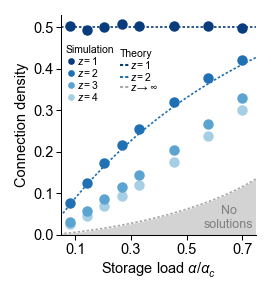

In [11]:
fig, ax = plt.subplots(figsize=(4.3*cm, 4.7*cm), nrows=1, ncols=1, gridspec_kw={'height_ratios':[1]})

ax.axhline(0.5, color=blues[0], linestyle=(0,(1.5,1.2)), lw=.8)
ax.plot(theory_l1['alpha_c'][:,0]/ac_50, theory_l1['p_exc'][:,0], color=blues[1], linestyle=(0,(1.5,1.2)), lw=.8)
for i_z in range(n_z):
    ax.errorbar(data_50['a']/ac_50, data_50['l0_mean'][i_z,0,:,:].mean(dim=-1), capsize=3, color=blues[i_z], fillstyle='full', ls='', marker='o', markersize=4, linewidth=0.5, zorder=10-i_z, clip_on=False)

ax.fill_between(theory_l2['alpha_0'][0]/ac_50, y1=0*theory_l2['l0'], y2=0.5*theory_l2['l0'] - 0.005, color='lightgray')
ax.plot(theory_l2['alpha_0'][0]/ac_50, 0.5*theory_l2['l0'], color='darkgray', linestyle=(0,(1.5,1.2)), lw=.8)
ax.text(0.65, 0.04, 'No\nsolutions', ha="center", va="center", color='gray', fontsize=6)

line1 = mlines.Line2D([], [], color=blues[0], linestyle='none', lw=2, marker='o', markersize=2.2)
line2 = mlines.Line2D([], [], color=blues[1], linestyle='none', lw=2, marker='o', markersize=2.2)
line3 = mlines.Line2D([], [], color=blues[2], linestyle='none', lw=2, marker='o', markersize=2.2)
line4 = mlines.Line2D([], [], color=blues[3], linestyle='none', lw=2, marker='o', markersize=2.2)
line5 = mlines.Line2D([], [], color='indianred', linestyle='--', lw=1.5)

leg1 = ax.legend([line4, line3, line2, line1], [r'$\mathit{z}=4$', r'$\mathit{z}=3$', r'$\mathit{z}=2$', r'$\mathit{z}=1$'], reverse=True,
          loc=(0.022,0.6), alignment='left', title='Simulation', fontsize=5, title_fontsize=5, frameon=False, labelspacing=0.0, handletextpad=.08, handlelength=1, borderpad=0)

line1 = mlines.Line2D([], [], color=blues[0], linestyle=(0,(1.5,1)), lw=1.)
line2 = mlines.Line2D([], [], color=blues[1], linestyle=(0,(1.5,1)), lw=1.)
line3 = mlines.Line2D([], [], color='darkgray', linestyle=(0,(1.5,1)), lw=1.)

ax.legend([line1, line2, line3], [r'$\mathit{z} = 1$', r'$\mathit{z} = 2$', r'$\mathit{z} \to \infty$'],
          loc=(0.3,0.645), alignment='left', title='Theory', fontsize=5, title_fontsize=5, frameon=False, labelspacing=0., handletextpad=.1, handlelength=0.9, borderpad=0)

ax.add_artist(leg1)

ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_xlim([0.05, 0.75])
ax.set_ylim([0, 0.53])
ax.set_xticks([0.1, 0.3, 0.5, 0.7])
ax.set_xlabel(r'Storage load $\it{\alpha / \alpha_c}$')
ax.set_ylabel(r'Connection density')

fig.show()

## Distribution of *surviving* connection weights

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/988136486.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


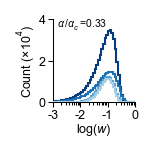

In [158]:
fig, ax = plt.subplots(figsize=(2.3*cm, 2.3*cm), nrows=1, ncols=1)

for i_z in range(n_z):
    w_50 = data_50['u'][i_z,:].pow(i_z+1).numpy() # compute w with recorded u-values
    w_50 = w_50[w_50>1e-10] # choose only survivors with the cutoff being 1e-10
    w_50 *= 0.1/w_50.mean() # normalize the mean
    hist_vals, hist_edges = np.histogram(w_50, bins=np.geomspace(1e-3, 1, 50))
    h_n = ax.stairs(hist_vals, hist_edges, color=blues[i_z], alpha=1, lw=1., zorder=i_z)

ax.text(14e-4, 3.6e4, r'$\it \alpha \, / \alpha_c =\!0.33$', size=5)
ax.set_xscale('log')
ax.set_xlim([10e-4, 1])
ax.set_xticks([1e-3, 1e-2, 1e-1, 1], [-3, -2, -1, 0], size=6)
ax.set_ylim([0, 4e4])
ax.set_yticks([0, 2e4, 4e4], [0, 2, 4], size=6)
ax.set_ylabel(r'Count ($\times 10^4$)', labelpad=0, size=6)
ax.set_xlabel(r'$log(\it{w})$', labelpad=0, size=6)

fig.show()

## Distribution of *all* connection weights

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_1256/2867968484.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


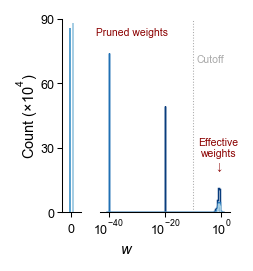

In [284]:
fig, axs = plt.subplots(figsize=(4*cm, 4*cm), nrows=1, ncols=2, width_ratios=[1, 7])

for i_z in range(n_z):
    w_50 = data_50['u'][i_z,:].pow(i_z+1).numpy() # compute w with recorded u-values
    w_50s = w_50[w_50>1e-10] # choose only survivors with the cutoff being 1e-10
    w_50 *= 0.1/w_50s.mean() # normalize the mean for the survivors
    hist_vals, hist_edges = np.histogram(w_50, bins=np.geomspace(1e-41, 1e1, 200))
    h_n = axs[1].stairs(hist_vals, hist_edges, color=blues[i_z], alpha=1, lw=0.7, zorder=i_z)

jitter = [0,0, -0.08, 0.08]
for i_z in range(2,4):
    w_50 = data_50['u'][i_z,:].pow(i_z+1).numpy() # compute w with recorded u-values
    w_50d = w_50[w_50==0] # filter out weights that are exactly 0
    axs[0].bar(jitter[i_z], w_50d.size, color=blues[i_z], width=0.12)

axs[1].text(1e-9, 7e5, 'Cutoff', size=5., color='darkgray')
fig.text(0.52, 0.92, 'Pruned weights', size=5, ha='center', va='top', color='darkred')
axs[1].text(1e-1, 35e4, 'Effective\nweights\n'+r'$\downarrow$', size=5., ha='center', va='top', color='darkred')
axs[1].axvline(1e-10, ls=':', c='darkgray', lw=0.5)

axs[1].set_xscale('log')
axs[1].set_xticks([1e-40, 1e-20, 1], [r'$10^{-40}$', r'$10^{-20}$', r'$10^{0}$'], size=6)
axs[1].tick_params(axis='x', which='major', pad=0)
axs[1].set_ylim([0, 9e5])
axs[1].set_yticks([])
axs[1].spines['left'].set_visible(False)

axs[0].set_xlim([-0.5, 0.5])
axs[0].set_xticks([0], [0], size=6)
axs[0].tick_params(axis='x', which='major', pad=2.5)
axs[0].set_ylim([0, 9e5])
axs[0].set_yticks([0, 3e5, 6e5, 9e5], [0, 30, 60, 90], size=6)
axs[0].set_ylabel(r'Count ($\times 10^4$)', labelpad=0, size=7)

fig.supxlabel(r'$\it{w}$', size=7, y=-0.05)

fig.show()

fig.savefig('./fig2_distr-w-50-ALL2.pdf', dpi=300, bbox_inches='tight', pad_inches=0.02*cm)